In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-01-10 09:03:04--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2021-01-10 09:03:04 (53.7 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



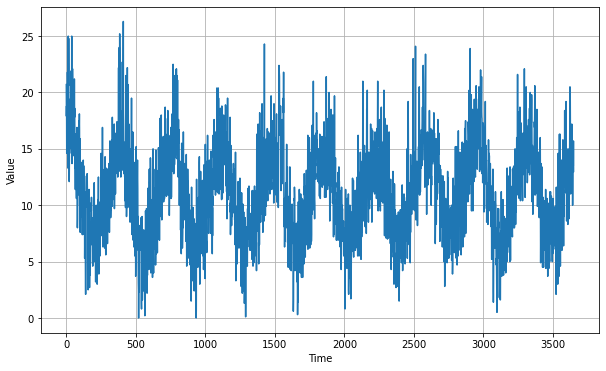

In [3]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 9s 30ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 0s 29ms/step - loss: 30.7698 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 0s 27ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 0s 29ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 0s 29ms/step - loss: 24.0420 - mae: 24.5384
Epoch 8/100
10/10 [==============================] - 0s 28ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 0s 29ms/step - loss: 18.2363 - mae: 18.7317
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

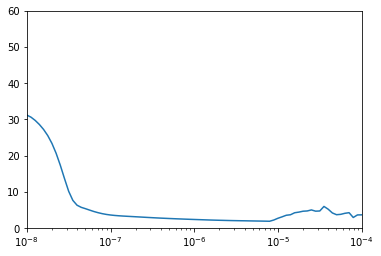

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])



optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 3s 15ms/step - loss: 12.5626 - mae: 13.0494
Epoch 2/150
25/25 [==============================] - 0s 14ms/step - loss: 3.6031 - mae: 4.0839
Epoch 3/150
25/25 [==============================] - 0s 16ms/step - loss: 2.3592 - mae: 2.8213
Epoch 4/150
25/25 [==============================] - 0s 15ms/step - loss: 2.1525 - mae: 2.6105
Epoch 5/150
25/25 [==============================] - 0s 15ms/step - loss: 2.0748 - mae: 2.5329
Epoch 6/150
25/25 [==============================] - 0s 14ms/step - loss: 2.1021 - mae: 2.5599
Epoch 7/150
25/25 [==============================] - 0s 15ms/step - loss: 2.0792 - mae: 2.5371
Epoch 8/150
25/25 [==============================] - 0s 14ms/step - loss: 1.9928 - mae: 2.4477
Epoch 9/150
25/25 [==============================] - 0s 15ms/step - loss: 1.8975 - mae: 2.3515
Epoch 10/150
25/25 [==============================] - 0s 16ms/step - loss: 1.9039 - mae: 2.3579
Epoch 11/150
25/25 [===========================

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

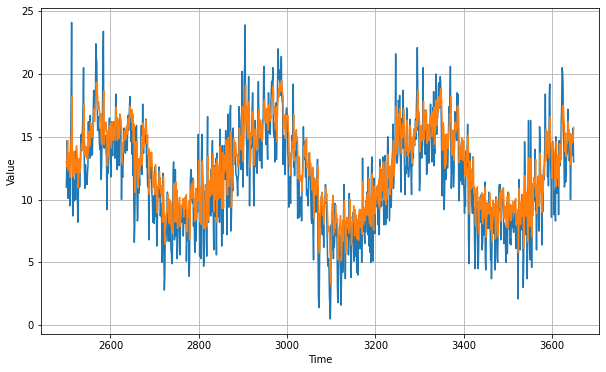

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.9245969

In [13]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[13.026956 12.646249 13.731774 ... 14.552678 14.632726 15.748829]
